- name: dataAna.ipynb
- date: Nov. 21, 2024
- contact: JiaoWu2020@gmail.com
- environment: Python 3.11.9

## Environment preparation

In [105]:
# import packages
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from sklearn.linear_model import LinearRegression as lm
from scipy import stats
import math
import random as rnd
import warnings

In [106]:
# get the working directories
codeDir = os.getcwd()
rootDir = os.path.abspath(os.path.join(codeDir, '..'))
oriDataDir = os.path.join(rootDir, '../seq_follow_pilot/data')
dataDir = os.path.join(rootDir, 'data')
figsDir = os.path.join(rootDir, 'figures')
statDir = os.path.join(rootDir, 'stats')

# set parameters
sns.set_context("notebook", font_scale=1.25)

# ignore warnings in pandas
pd.options.mode.chained_assignment = None # default='warn'

In [107]:
# define function for multiple linear regression
def LM_2F(data, factors):
    parList = data.nPar.unique()
    nPar = parList.size
    slope_f1 = np.zeros(nPar)
    slope_f2 = np.zeros(nPar)
    intercept = np.zeros(nPar)
    for i in range(nPar):
        iPar = parList[i]
        tmp = data.query('nPar == @iPar')
        reg = lm().fit(tmp[[factors[0],factors[1]]], tmp[factors[2]])
        slope_f1[i-1] = reg.coef_[0]
        slope_f2[i-1] = reg.coef_[1]
        intercept[i-1] = reg.intercept_ 
    return slope_f1, slope_f2, intercept

# define function for simple linear regression
def LM_1F(data,factors):
    parList = data.nPar.unique()
    nPar = parList.size
    slope = np.zeros(nPar)
    intercept = np.zeros(nPar)
    for i in range(nPar):
        iPar = parList[i]
        tmp = data.query('nPar == @iPar')
        reg = lm().fit(tmp[[factors[0]]], tmp[factors[1]])
        slope[i] = reg.coef_[0]
        intercept[i] = reg.intercept_ 
    return slope, intercept

# define function to do repeated measures ANOVA with Greenhouse-Geisser corrections
# provided long-format data
def rmANOVA_gg_Long(data, dv, within, subject):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        if len(within) == 1:
            GGpass = pg.sphericity(data, dv=dv, subject=subject, within=within, method='greenhouse-geisser')[0]
            aov = pg.rm_anova(data=data, dv=dv, within=within, subject=subject, detailed=True, effsize="np2", correction= not GGpass)
            if not GGpass:
                aov['DF-GG-corr'] = aov['DF'] * aov['eps'][0]
                aov.drop(columns=['sphericity', 'W-spher', 'p-spher'], inplace=True)
                print('* The assumption of sphericity is violated for factor:', within)
            return aov
        elif len(within) == 2:
            GGpass = pd.Series([True,True,True])
            factorDict = {"0":within[0], "1":within[1], "2":within}
            for i in range(3):
                GGpass[i] = pg.sphericity(data, dv=dv, subject=subject, within=factorDict[str(i)], method='greenhouse-geisser')[0]
                if not GGpass[i]:
                    print('* The assumption of sphericity is violated for factor:', factorDict[str(i)])
            aov = pg.rm_anova(data=data, dv=dv, within=within, subject=subject, detailed=True, effsize="np2", correction=True)
            eps = pd.Series([1,1,1])
            GGcrr = [not x for x in GGpass]
            eps[GGcrr] = aov['eps'][GGcrr]
            aov['DF1-GGcrr'] = aov['ddof1'] * eps
            aov['DF2-GGcrr'] = aov['ddof2'] * eps
            return aov


## Data loading and preparation

In [108]:
# get the list of data files
csv_files = glob.glob(os.path.join(oriDataDir, "seq_tasks_v2023_s*.csv"))
data = pd.DataFrame()

# read files and transform data
for i in range(len(csv_files)):
    parCSV = pd.read_csv(csv_files[i])

    # get useful columns
    df = parCSV.rename(columns = {'participant':'nPar', 'trials.thisRepN':'nB',\
            'trials.thisTrialN':'nT', 'duration':'curDur','cue':'curTask',\
            'rpr_duration':'rpr','follow_stimuli':'curflwDur','follow_production':'flw'})
    df = df[['nPar','nB','nT','curDur','curTask','rpr','curflwDur','flw']] # select columns

    # data transformation
    df = df.query('nB>0 & nPar.notnull()') # remove practice and rows with missing values
    df.nT = df.nT + 1 # convert nT to start from 1
    df['nT'] = df['nT'].astype(int) # convert nT to integer
    df['nB'] = df['nB'].astype(int) # convert nB to integer
    df['curflwDur'] = df['curflwDur'].round(1)
    df['nPar'] = df['nPar'].apply(lambda x: x[1:] if isinstance(x, str) else x)
    df['nPar'] = df['nPar'].astype(int)
    # exchange 'curDur' with 'curflwDur' in following condition, 
    # making 'curDur' to be the duration that observers made responses
    df.loc[df['curTask']=='following','curPreCueDur'] = df['curDur']
    df.loc[df['curTask']=='following','curDur'] = df['curflwDur']
    # add columns for previous task, duration, and report (trial n-1)
    df['preTask'] = df['curTask'].shift(periods=1)
    df.loc[df['nT']==1, ['preTask']] = pd.NA
    df['preDur'] = df['curDur'].shift(periods=1)
    df.loc[df['nT']==1, ['preDur']] = pd.NA
    df.loc[df['curTask']=='reproduction', 'curRpt'] = df['rpr']
    df.loc[df['curTask']=='following', 'curRpt'] = df['flw']
    df['preRpt'] = df['curRpt'].shift(periods=1)
    df.loc[df['nT']==1, ['preRpt']] = pd.NA
    df['prePreCueDur'] = df['curPreCueDur'].shift(periods=1)
    df.loc[df['nT']==1, ['prePCDur']] = pd.NA
    df = df[['nPar','nB','nT','curTask','curDur','rpr','flw','curPreCueDur','curRpt','preTask','preDur','preRpt','prePreCueDur']]
    # append the data
    data = pd.concat([data, df], ignore_index=True)

data.to_csv(os.path.join(dataDir, 'data_ori.csv'), index=False)

In [109]:
# data cleaning
data = pd.read_csv(dataDir + '/data_ori.csv')

# 1. get the distribution and Q-Q plot for reproduction (rpr) and follow (flw) responses
print('rpr range:[',data.query('rpr>0')['rpr'].min(),',',data.query('rpr>0')['rpr'].max(),']')
# df.query('rpr>0')['rpr'].hist(bins=20, color='grey', edgecolor='black') # & rpr < 0.9
# plt.show()
# stats.probplot(df.query('rpr>0')['rpr'], dist="norm", plot=plt)
# plt.title("Q-Q Plot (rpr)")
# plt.show()

print('flw range:[',data.query('flw>0')['flw'].min(),',',data.query('flw>0')['flw'].max(),']')
# df.query('flw>0')['flw'].hist(bins=20, color='grey', edgecolor='black') # & flw<0.9
# plt.show()
# stats.probplot(df.query('flw>0')['flw'], dist="norm", plot=plt)
# plt.title("Q-Q Plot (flw)")
# plt.show() 

# 2. remove outliers
data['valid'] = 1 # no outliers in rpr and flw for current pilot data
data.loc[data.query('(rpr>0 & rpr<0.2) | rpr>3 | (flw>0 & flw<0.2)').index,'valid'] = 0 # 

# 3. save the cleaned data
data.to_csv(os.path.join(dataDir, 'dataAll.csv'), index=False)

rpr range:[ 0.0353018000005249 , 7.021174099998461 ]
flw range:[ 0.1176125000001775 , 2.3286392000009073 ]


In [110]:
data.query('valid==0')

,nPar,nB,nT,curTask,curDur,rpr,flw,curPreCueDur,curRpt,preTask,preDur,preRpt,prePreCueDur,valid
866,2,6,27,following,0.9,0.000000,0.141121,0.9,0.141121,following,1.2,0.917318,1.4,0
948,2,7,53,following,1.1,0.000000,0.164636,1.1,0.164636,reproduction,0.8,0.752694,NaN,0
990,2,8,39,reproduction,0.9,0.141165,0.000000,NaN,0.141165,reproduction,1.3,1.399601,NaN,0
1085,2,10,22,following,0.8,0.000000,0.176414,0.8,0.176414,following,1.2,1.199621,1.4,0
1891,5,4,44,following,1.0,0.000000,0.164635,0.9,0.164635,reproduction,1.3,1.023267,NaN,0
2183,5,9,56,reproduction,1.1,3.057904,0.000000,NaN,3.057904,reproduction,1.3,1.399575,NaN,0
2305,4,2,10,reproduction,1.2,0.141159,0.000000,NaN,0.141159,reproduction,0.8,1.129101,NaN,0
2451,4,4,44,reproduction,1.3,3.410786,0.000000,NaN,3.410786,reproduction,1.0,0.799746,NaN,0
2457,4,4,50,reproduction,0.9,7.021174,0.000000,NaN,7.021174,following,1.4,1.070545,0.8,0
2488,4,5,25,reproduction,1.2,3.869561,0.000000,NaN,3.869561,reproduction,1.4,1.140853,NaN,0


In [111]:
# import data
data = pd.read_csv(dataDir + '/dataAll.csv')
dataValid = data.query('valid == 1') #  & nPar != 1

# get parameters
nPar = len(dataValid.nPar.unique())
print('Number of participants: ' + str(nPar))

# get dataframe for current and previous trial analyses
dataRpr = dataValid.query('curTask == "reproduction"')
dataRpr['curBias'] = dataRpr['rpr'] - dataRpr['curDur']
dataRpr_pre = dataRpr.query('preTask.notnull()')

dataFlw = dataValid.query('curTask == "following"')
dataFlw['curBias'] = dataFlw['flw'] - dataFlw['curDur']
dataFlw_pre = dataFlw.query('preTask.notnull()')

# dataValid.head()

Number of participants: 6


## 1. Reproduction task performance

### 1.1 Overall reproduction bias

In [112]:
# overall mean bias
genRprBias = dataRpr.groupby(['nPar']).curBias.mean().reset_index()
print(genRprBias)
print('mean rpr Bias:',genRprBias["curBias"].mean().round(3))
print('SE of rpr Bias:',genRprBias["curBias"].sem().round(3))
# print('【The overall bias compared to zero】')
# print(pg.ttest(genRprBias['curBias'], 0).round(3))

   nPar   curBias
0     1  0.094192
1     2 -0.000196
2     3 -0.049501
3     4 -0.098482
4     5  0.004039
5     6 -0.143008
mean rpr Bias: -0.032
SE of rpr Bias: 0.034


mean of overall CV: 0.241
SE of overall CV: 0.018


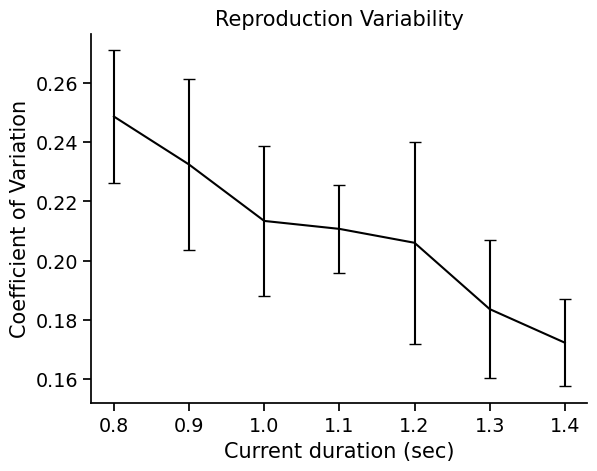

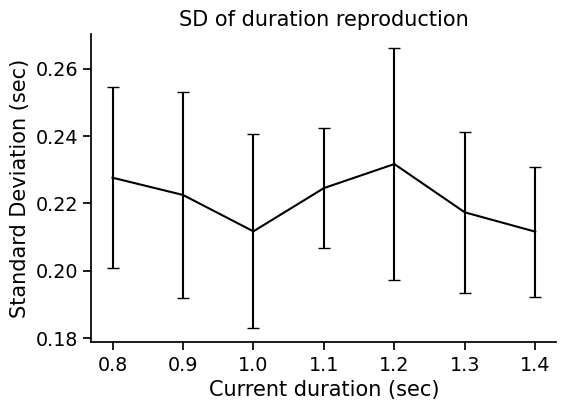

In [113]:
# overall mean reproduction CV
RprCV = dataRpr.groupby(['nPar']).agg({"rpr":["count","mean","std"]}).reset_index()
RprCV.columns = ['nPar', 'count', 'mean','std']
RprCV['cv'] = RprCV['std']/RprCV['mean']
# print(RprCV)
print('mean of overall CV:',RprCV["cv"].mean().round(3))
print('SE of overall CV:',RprCV["cv"].sem().round(3))
# print('【The overall CV compared to zero】')
# print(pg.ttest(RprCV['cv'], 0).round(3))

# mean CV as a factor of duration
mCVPar = dataRpr.groupby(['nPar', 'curDur']).\
    agg({"rpr":["count","mean","std"]}).reset_index()
mCVPar.columns = ['nPar', 'curDur','count', 'mean','std']
mCVPar['cv'] = mCVPar['std']/mCVPar['mean']
mCVAll = mCVPar.groupby(['curDur']).agg({"cv":["count","mean","sem"]}).reset_index()
mCVAll.columns = ['curDur', 'count', 'mCV','seCV']
# print(mCVAll)
# print('【rmANOVA: Duration main effect on mean CV】')
# aov_cv_dur = rmANOVA_gg_Long(mCVPar, 'cv', ['curDur'], 'nPar')
# print(aov_cv_dur)

# plot CV
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mCV', yerr='seCV', data=mCVAll, 
             color='black', capsize=4)
plt.xticks(mCVAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Coefficient of Variation')
plt.title('Reproduction Variability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot SD
mSDAll = mCVPar.groupby(['curDur']).agg({"std":["count","mean","sem"]}).reset_index()
mSDAll.columns = ['curDur', 'count', 'mSD','seSD']
#print(mSDAll)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.errorbar(x='curDur',y='mSD',yerr='seSD',data=mSDAll,color='black',capsize=4)
plt.xticks(mSDAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Standard Deviation (sec)')
plt.title('SD of duration reproduction')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

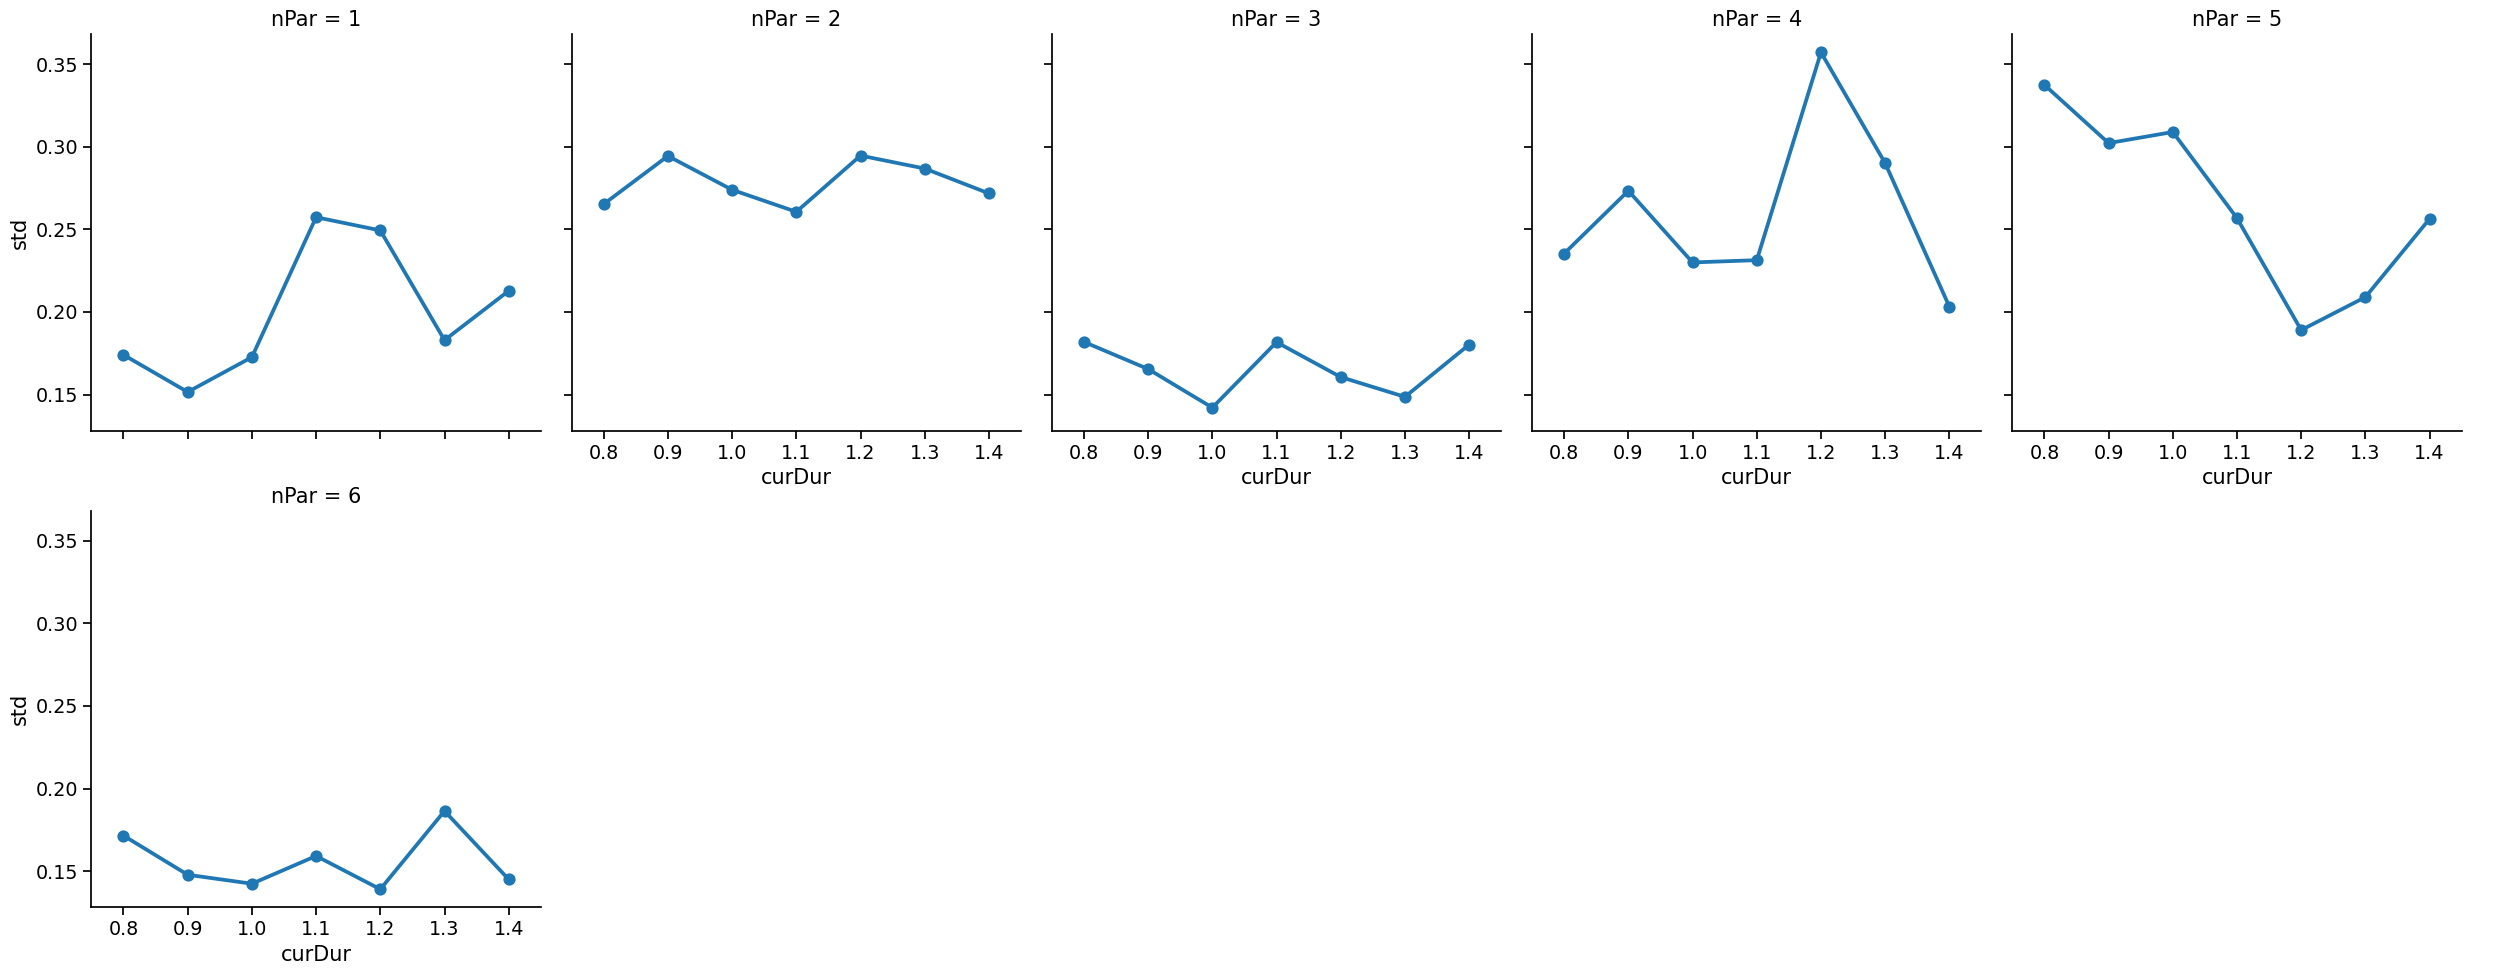

In [114]:
# quickly visualize the individual data
sns.catplot(data = mCVPar, kind = 'point', 
            x = 'curDur', y = 'std', col = 'nPar', col_wrap = 5)

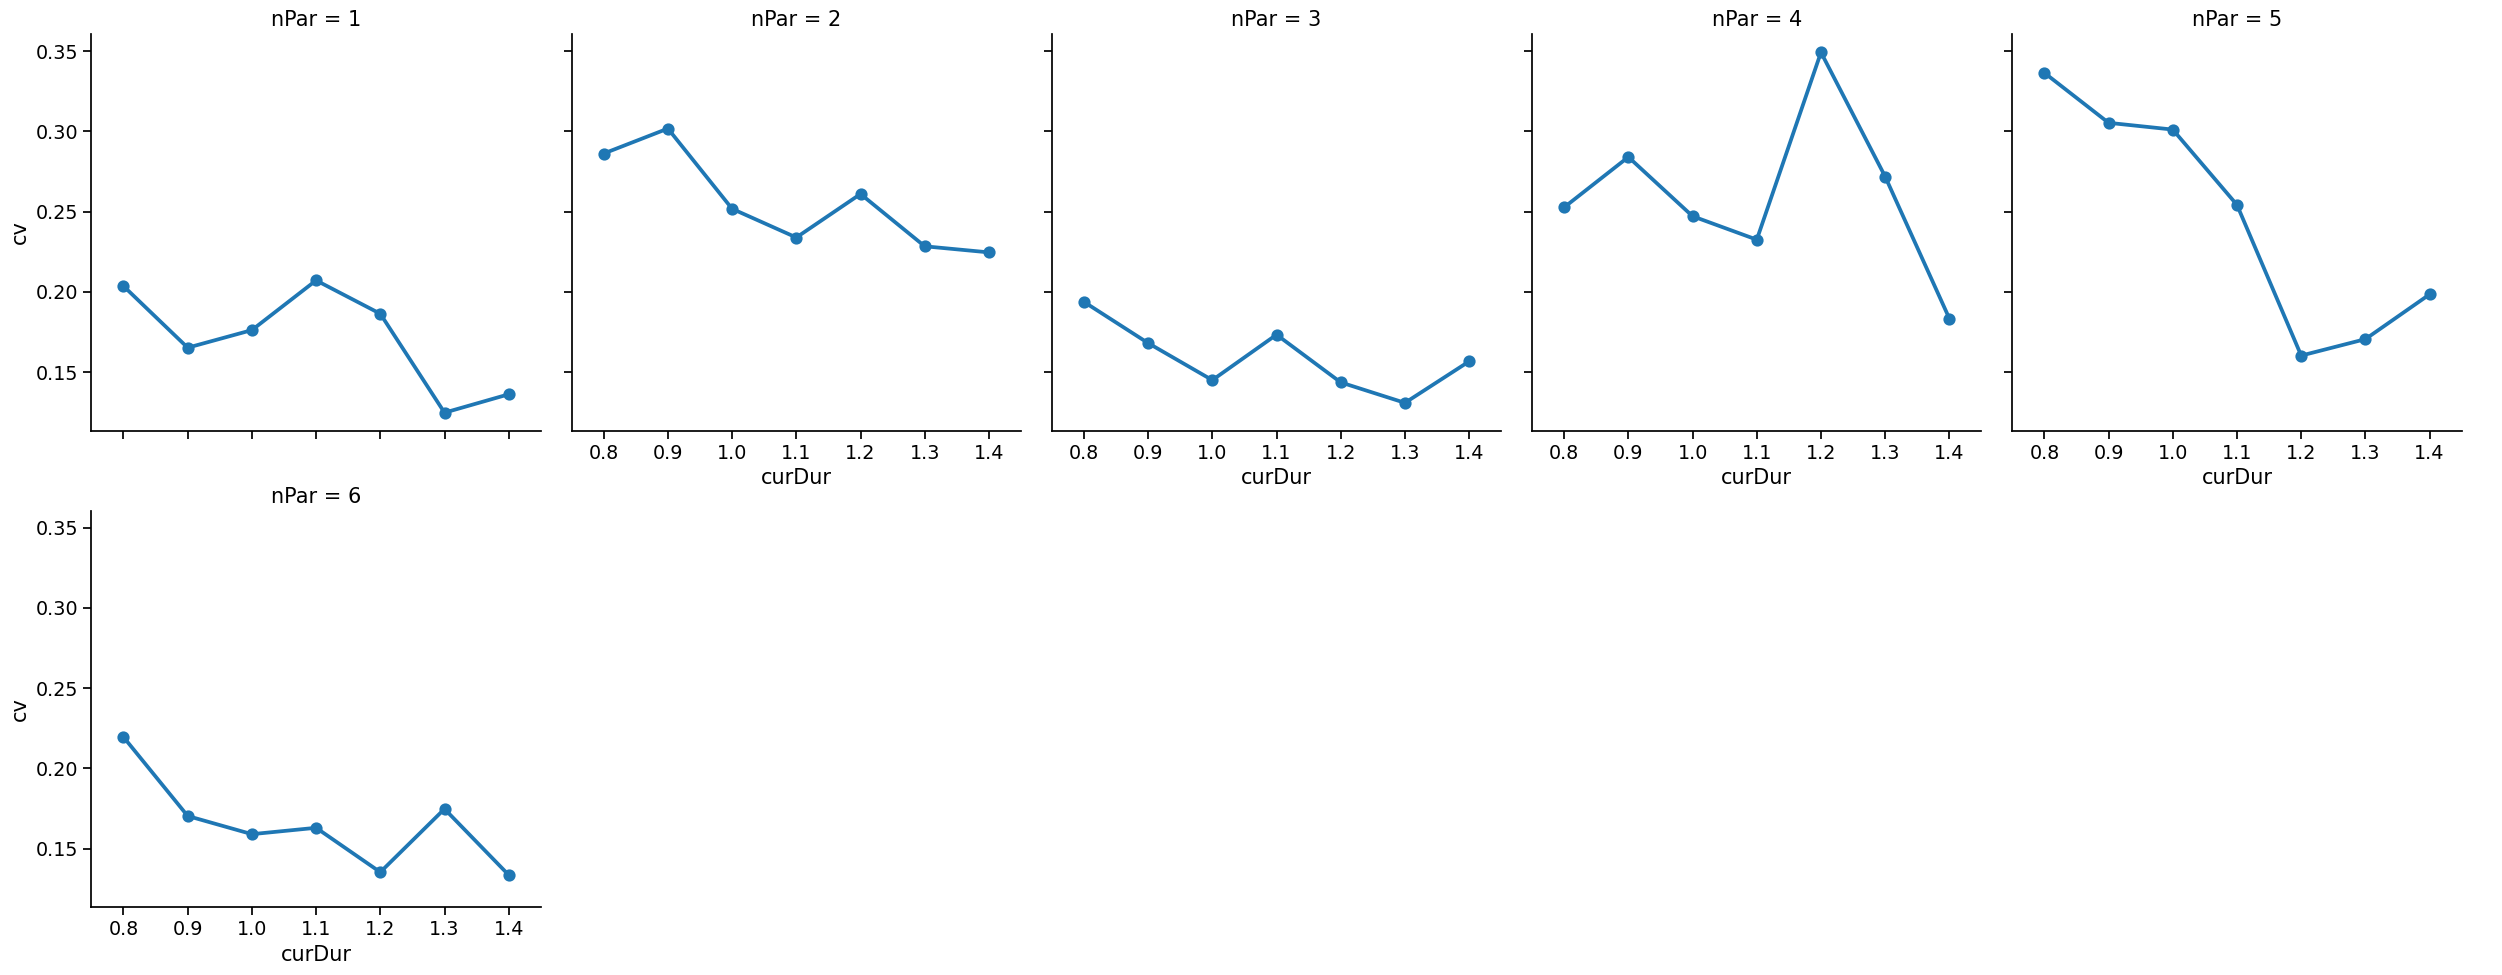

In [115]:
# quickly visualize the individual data
sns.catplot(data = mCVPar, kind = 'point', 
            x = 'curDur', y = 'cv', col = 'nPar', col_wrap = 5)

### 1.2 Central tendency effect

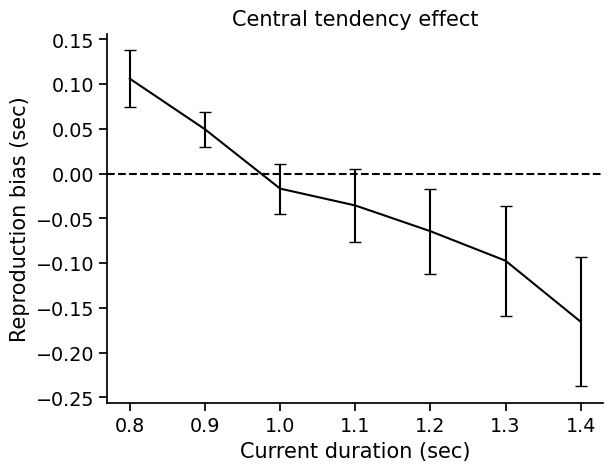

In [116]:
# Central tendency based on Reproduction Bias
mBiasDurPar = dataRpr.groupby(['nPar', 'curDur']).curBias.mean().reset_index()
mBiasDurAll = mBiasDurPar.groupby('curDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mBiasDurAll.columns = ['curDur', 'count', 'mBias','seBias']
#print(mBiasDurAll)

# rmANOVA: mean bias as a factor of duration
# print('【rmANOVA: Duration main effect on mean bias】')
# aov_bias_dur = rmANOVA_gg_Long(mBiasDurPar, 'curBias', ['curDur'], 'nPar')
# print(aov_bias_dur)

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mBias', yerr='seBias', data=mBiasDurAll, 
             color='black', capsize=4)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mBiasDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Reproduction bias (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(figsDir + '/CT_RprErr.png', bbox_inches='tight')

# # Central tendency based on Reproduction
# mRprDurPar = dataRpr.groupby(['nPar', 'curDur']).rpr.mean().reset_index()
# mRprDurAll = mRprDurPar.groupby('curDur').\
#     agg({"rpr":["count","mean","sem"]}).reset_index()
# mRprDurAll.columns = ['curDur', 'count', 'mRpr','seRpr']
# #print(mRprDurAll)

# # plot central tendency
# fig, ax = plt.subplots()
# plt.errorbar(x='curDur', y='mRpr', yerr='seRpr', data=mRprDurAll, 
#              color='black', capsize=4)
# plt.plot([0.8, 1.4], [0.8, 1.4], 'k-', lw=1, dashes=[2, 2])
# plt.xticks(mRprDurAll.curDur)
# plt.xlabel('Current duration (sec)')
# plt.ylabel('Reproduction (sec)')
# plt.title('Central tendency effect')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# #plt.savefig(figsDir + '/CT_Rpr.png', bbox_inches='tight')

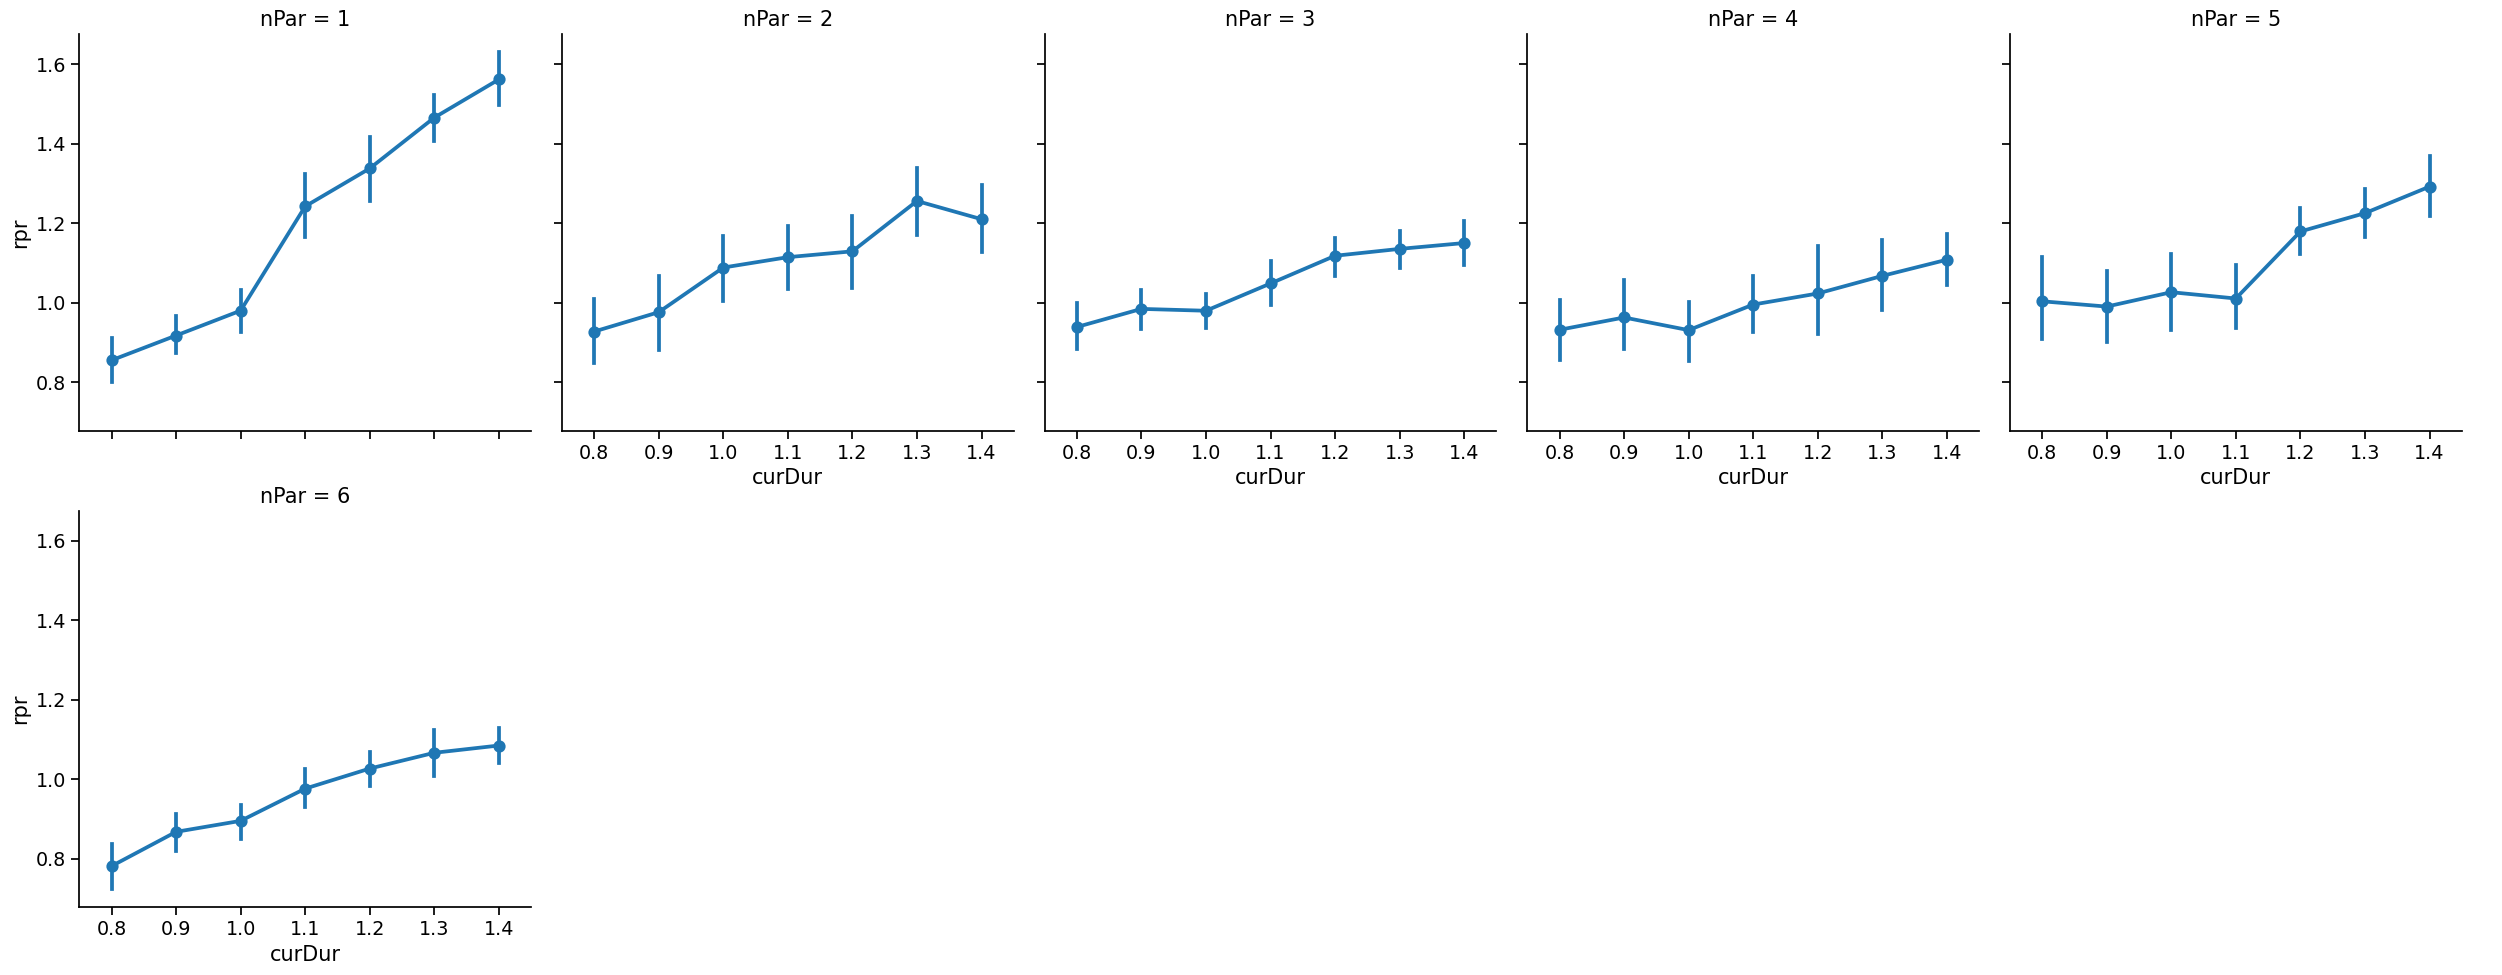

In [117]:
# quickly visualize the individual data
sns.catplot(data = dataRpr, kind = 'point', 
            x = 'curDur', y = 'rpr', col = 'nPar', col_wrap = 5)

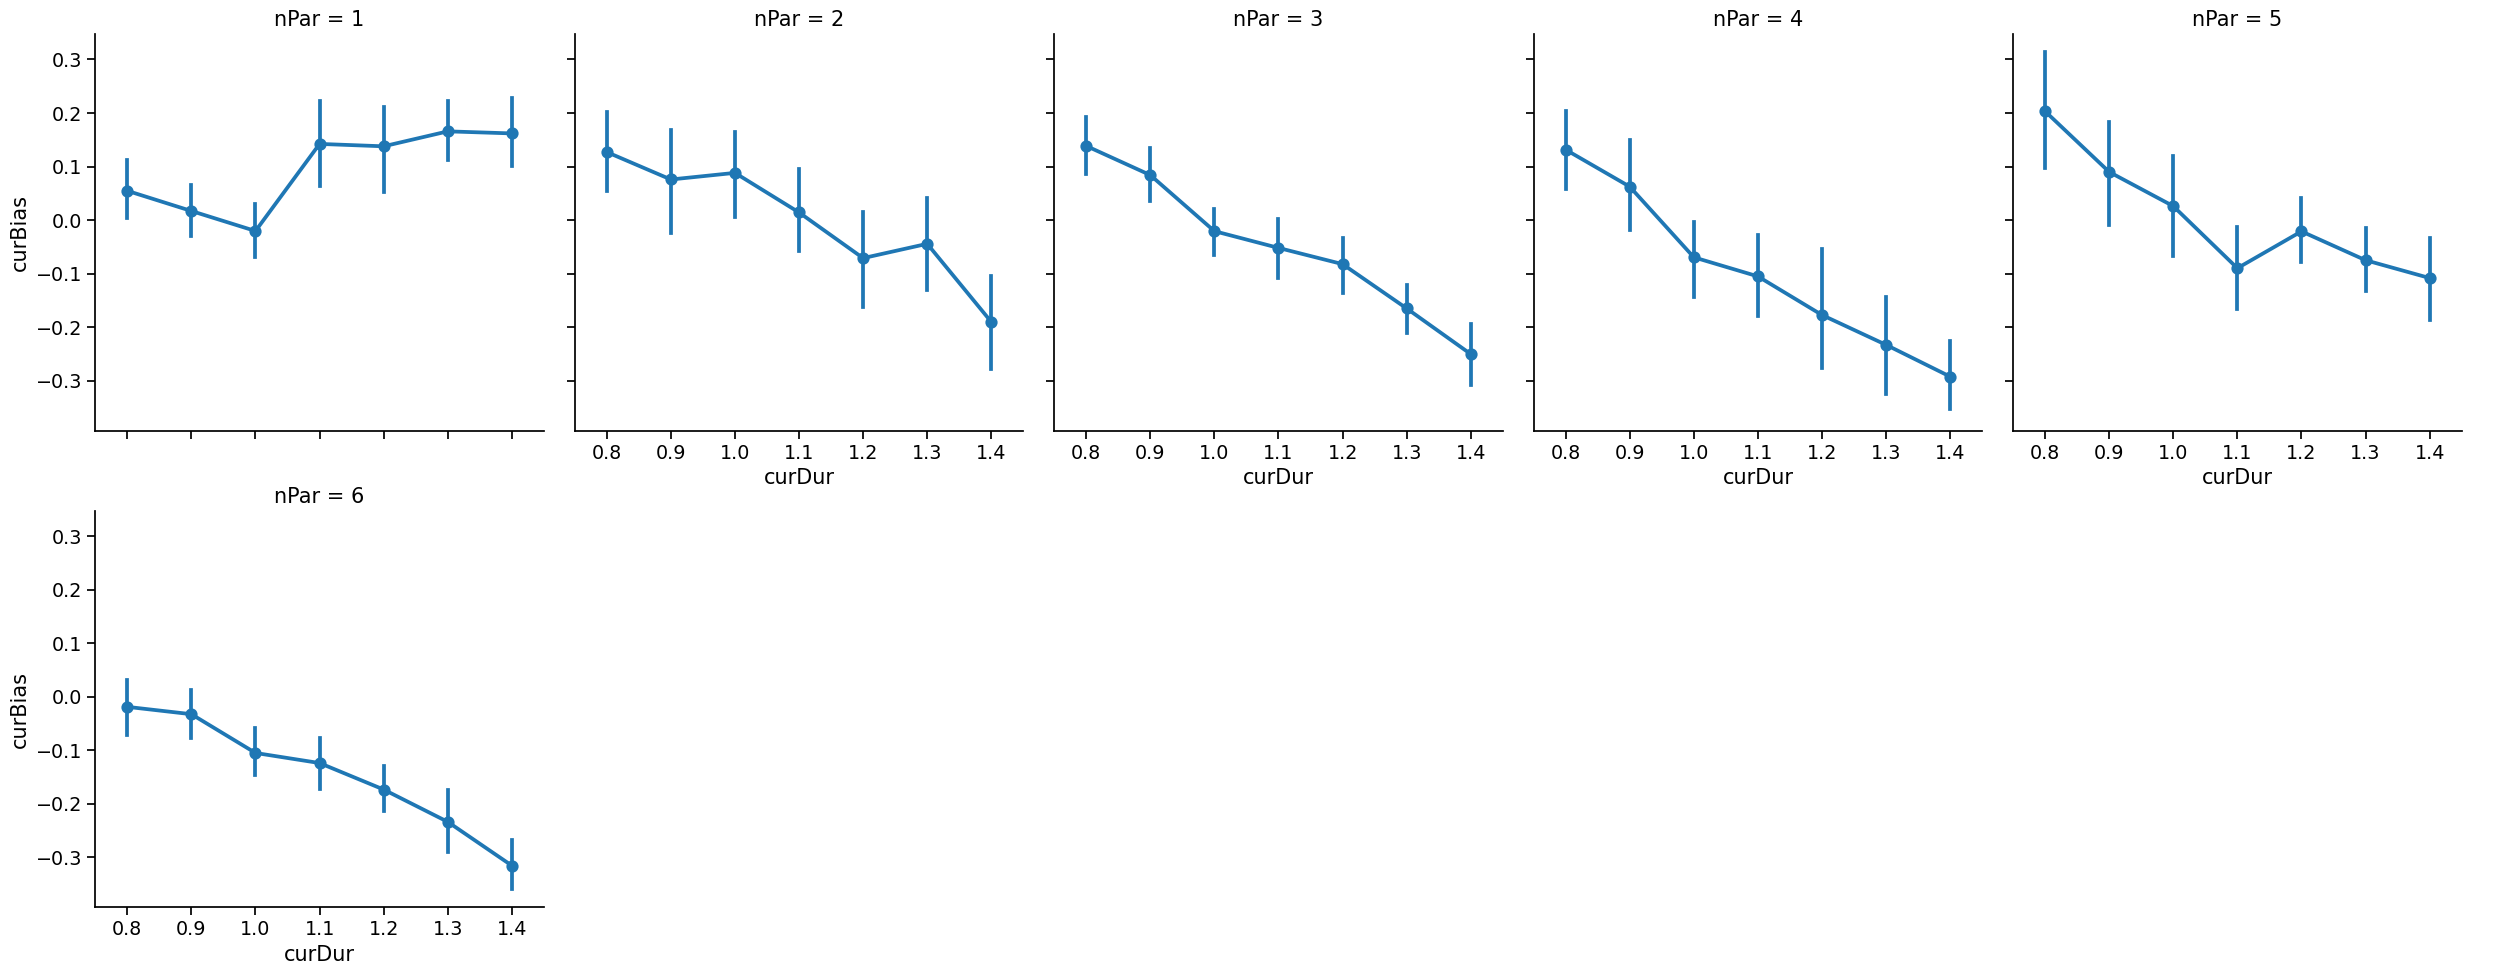

In [118]:
# quickly visualize the individual data
sns.catplot(data = dataRpr, kind = 'point', 
            x = 'curDur', y = 'curBias', col = 'nPar', col_wrap = 5)

### 1.3 Sequential effect or Serial dependence

In [119]:
# overall Sequential effect (based on Reproduction Bias)
mBiasPreDurPar = dataRpr_pre.groupby(['nPar','preDur']).curBias.mean().reset_index()
mBiasPreDurAll = mBiasPreDurPar.groupby('preDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mBiasPreDurAll.columns = ['preDur', 'count', 'mBias','seBias']
# print(mBiasPreDurAll)

# rmANOVA: mean bias as a factor of pre-duration
# print('【rmANOVA of mean Bias on preDuration】')
# aov_bias_preDur = rmANOVA_gg_Long(mBiasPreDurPar, 'curBias', ['preDur'], 'nPar')
# print(aov_bias_preDur)

# plot sequential effect
# fig, ax = plt.subplots()
# plt.errorbar(x='preDur', y='mBias', yerr='seBias', data=mBiasPreDurAll, 
#              color='black', capsize=4)
# plt.axhline(y=0, color='black', linestyle='--')
# plt.xticks(mBiasPreDurAll.preDur)
# plt.xlabel('Duration of previous n-1 trial (sec)')
# plt.ylabel('Reproduction bias (sec)')
# plt.title('overall Sequential effect')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_RprErr.png', bbox_inches='tight')

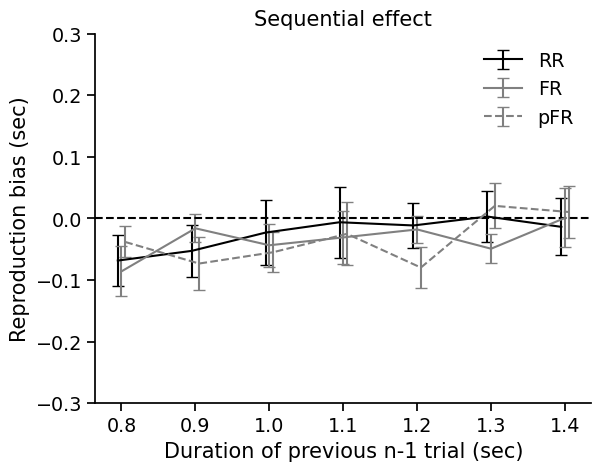

In [120]:
# Sequential effect between RR and FR
seqTaskPar = dataRpr_pre.groupby(['nPar', 'preTask', 'preDur']).curBias.mean().reset_index()
seqTaskAll = seqTaskPar.groupby(['preTask', 'preDur']).\
    agg({"curBias":["count","mean","sem"]}).reset_index()
seqTaskAll.columns = ['preTask', 'preDur', 'count', 'mBias','seBias']
# print(seqTaskAll)

# plot sequential effect between RR and JR
data_RR = seqTaskAll.query('preTask=="reproduction"')
data_FR = seqTaskAll.query('preTask=="following"')
data_pFR = dataRpr_pre.query('preTask=="following"').\
    groupby(['nPar', 'prePreCueDur']).curBias.mean().reset_index().\
    groupby(['prePreCueDur']).agg({"curBias":["count","mean","sem"]}).reset_index()
data_pFR.columns = ['prePreCueDur', 'count', 'mBias','seBias']

fig, ax = plt.subplots()
ax.errorbar(data_RR.preDur-0.005, data_RR.mBias, data_RR.seBias, 
             color='black', capsize=4, label='RR')
ax.errorbar(data_FR.preDur, data_FR.mBias, data_FR.seBias, 
             color='grey', capsize=4, label='FR')
ax.errorbar(data_pFR.prePreCueDur+0.005, data_pFR.mBias, data_pFR.seBias, 
             color='grey', capsize=4, label='pFR', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(data_RR.preDur)
plt.ylim(-0.3, 0.3)
plt.xlabel('Duration of previous n-1 trial (sec)')
plt.ylabel('Reproduction bias (sec)')
plt.title('Sequential effect')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(figsDir + '/SeqEff_RRvsFR.png', bbox_inches='tight')

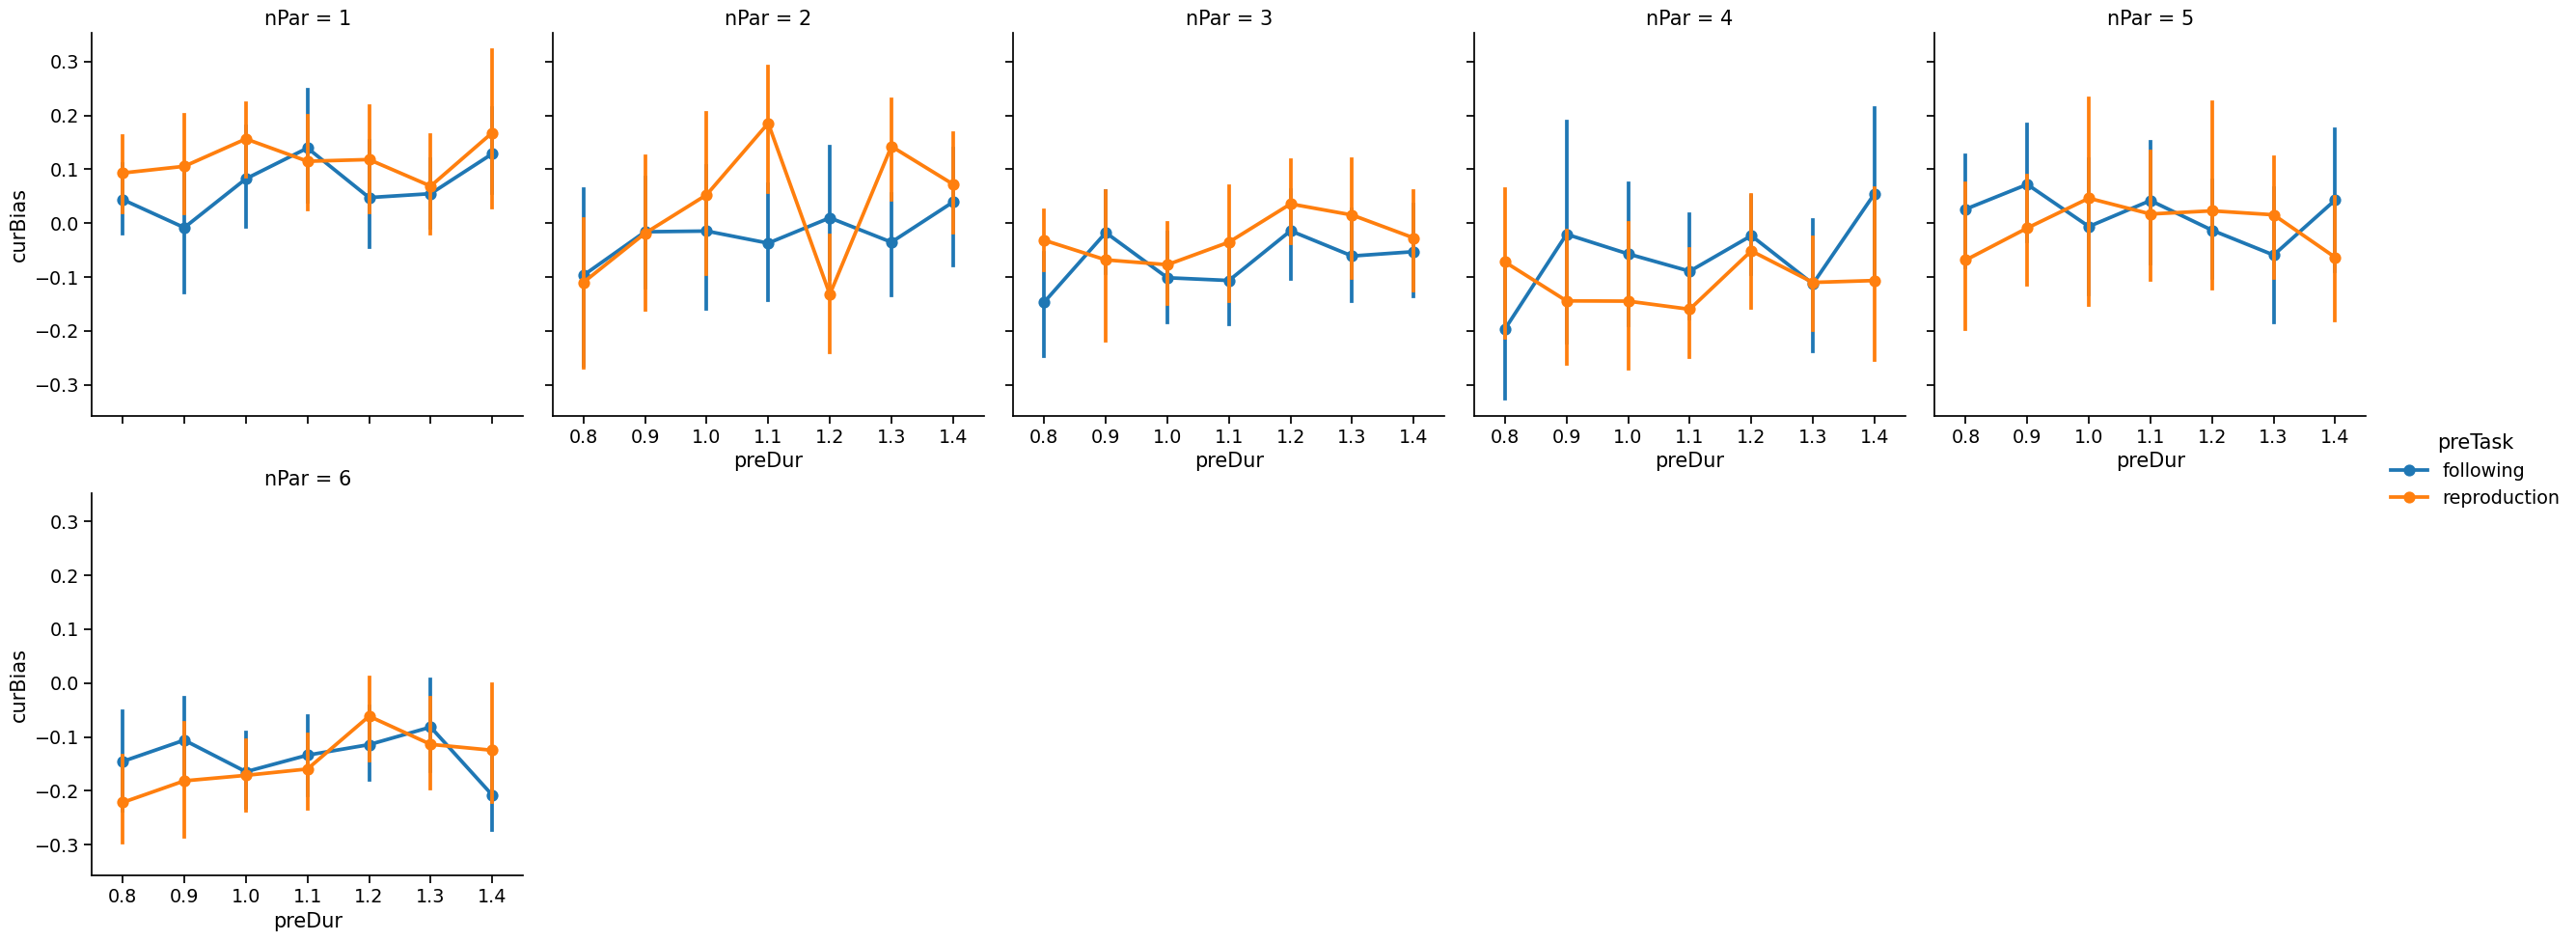

In [121]:
# quickly visualize the individual data
sns.catplot(data = dataRpr_pre, kind = 'point', 
            x = 'preDur', y = 'curBias', hue='preTask', col = 'nPar', col_wrap = 5)

mean SDI slope in RR:  0.077
std SDI slope in RR:  0.031
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  2.26797    5   two-sided  0.07262  [-0.01, 0.17]  0.92589  1.595   

          power  
T-test  0.45012  
mean SDI slope in FR:  0.088
std SDI slope in FR:  0.054
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  1.49177    5   two-sided  0.19596  [-0.06, 0.24]  0.60901  0.802   

          power  
T-test  0.22966  
【Comparison of SDI in RR vs FR】
              T  dof alternative   p-val          CI95%  cohen-d   BF10  \
T-test -0.15138    5   two-sided  0.8856  [-0.19, 0.16]  0.08754  0.377   

          power  
T-test  0.05359  
              T  dof alternative   p-val          CI95%  cohen-d   BF10  \
T-test  1.94403    5   two-sided  0.1095  [-0.04, 0.27]  0.79365  1.192   

          power  
T-test  0.35159  


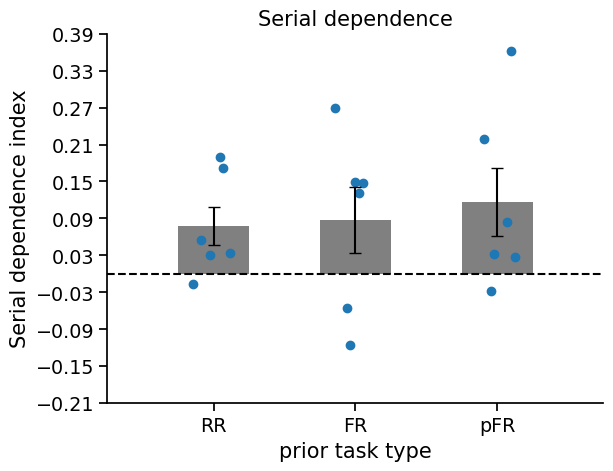

In [122]:
# calculate SDI and plot
dataRR = dataRpr_pre.query('preTask=="reproduction"')
dataFR = dataRpr_pre.query('preTask=="following"')

slp_1, slope_RR_sdi, int_1 = LM_2F(dataRR, ['curDur','preDur','curBias'])
print("mean SDI slope in RR: ", slope_RR_sdi.mean().round(3))
print("std SDI slope in RR: ", round(slope_RR_sdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_RR_sdi, 0).round(5))

slp_1, slope_FR_sdi, int_1 = LM_2F(dataFR, ['curDur','preDur','curBias'])
print("mean SDI slope in FR: ", slope_FR_sdi.mean().round(3))
print("std SDI slope in FR: ", round(slope_FR_sdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_FR_sdi, 0).round(5))

print("【Comparison of SDI in RR vs FR】")
print(pg.ttest(slope_RR_sdi, slope_FR_sdi, paired=True).round(5))

# calculate the serial dependence of pre-cue stimuli in follow condition
slp_1, slope_FR_psdi, int_1 = LM_2F(dataFR, ['curDur','prePreCueDur','curBias'])
print(pg.ttest(slope_FR_psdi, 0).round(5))

# # using simple linear regression
# slope_RR_sdi, int_1 = LM_1F(dataRR, ['preDur','curBias'])
# slope_FR_sdi, int_1 = LM_1F(dataFR, ['preDur','curBias'])
# slope_FR_psdi, int_1 = LM_1F(dataFR, ['prePreCueDur','curBias'])


## for pilot only
# reg = lm().fit(dataRR[['curDur', 'preDur']], dataRR['curBias'])
# slope_RR_cti = reg.coef_[0]
# slope_RR_sdi = reg.coef_[1]

# reg2 = lm().fit(dataFR[['curDur', 'preDur']], dataFR['curBias'])
# slope_FR_cti = reg2.coef_[0]
# slope_FR_sdi = reg2.coef_[1]

# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,4), [np.mean(slope_RR_sdi), np.mean(slope_FR_sdi), np.mean(slope_FR_psdi)], color='grey', width=0.5)
plt.errorbar(np.arange(1,4), [np.mean(slope_RR_sdi), np.mean(slope_FR_sdi), np.mean(slope_FR_psdi)],
             yerr=[np.std(slope_RR_sdi)/np.sqrt(nPar), np.std(slope_FR_sdi)/np.sqrt(nPar), np.std(slope_FR_psdi)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2, (np.random.random(nPar)-0.5)*0.3+3], \
            [slope_RR_sdi, slope_FR_sdi, slope_FR_psdi])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,3.75)
plt.xticks(np.arange(1,4), ['RR', 'FR','pFR'])
plt.yticks(np.arange(-0.21, 0.43, 0.06))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
plt.title('Serial dependence')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(figsDir + '/SeqEff_RRvsFR_SDI.png', bbox_inches='tight')

In [123]:
slp, b = LM_1F(dataFlw.query('curTask=="following"'), ['curDur','curPreCueDur'])
print(slp)

# plt.figure()
# sns.lmplot(data=dataFlw.query('curTask=="following"'), x="curDur", y="curPreCueDur", scatter_kws={"s": 4}) # 

[-0.0625421  -0.00422222  0.03431901 -0.00876238  0.06660346  0.00093105]


<Figure size 640x480 with 0 Axes>

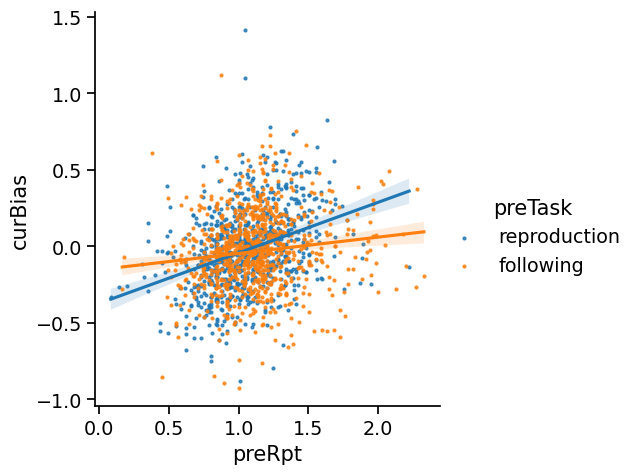

In [124]:
plt.figure()
sns.lmplot(data=dataRpr_pre.query('preRpt<3'), x="preRpt", y="curBias", hue='preTask', scatter_kws={"s": 4}) # 
plt.savefig(figsDir + '/SeqEff_RRvsFR_DCI_scatter.png', bbox_inches='tight')

mean SDI slope in RR:  0.278
std SDI slope in RR:  0.054
              T  dof alternative    p-val         CI95%  cohen-d    BF10  \
T-test  4.67187    5   two-sided  0.00547  [0.13, 0.43]  1.90728  10.883   

          power  
T-test  0.95714  
mean SDI slope in FR:  0.129
std SDI slope in FR:  0.064
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  1.82848    5   two-sided  0.12702  [-0.05, 0.31]  0.74647  1.075   

          power  
T-test  0.31826  
【Comparison of SDI in RR vs FR】
              T  dof alternative    p-val          CI95%  cohen-d BF10  \
T-test  1.74665    5   two-sided  0.14113  [-0.07, 0.37]  0.93173  1.0   

          power  
T-test  0.45457  


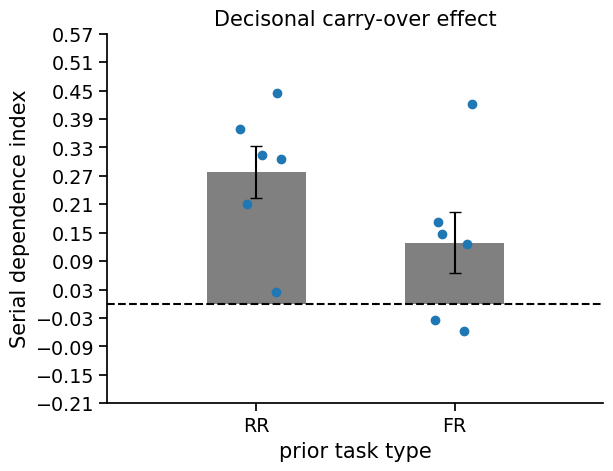

In [125]:
# calculate Decisional carry-over index (DCI) and plot
slp_1, slope_RR_dci, int_1 = LM_2F(dataRR, ['curDur','preRpt','curBias'])
print("mean SDI slope in RR: ", slope_RR_dci.mean().round(3))
print("std SDI slope in RR: ", round(slope_RR_dci.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_RR_dci, 0).round(5))

slp_1, slope_FR_dci, int_1 = LM_2F(dataFR, ['curDur','preRpt','curBias'])
print("mean SDI slope in FR: ", slope_FR_dci.mean().round(3))
print("std SDI slope in FR: ", round(slope_FR_dci.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_FR_dci, 0).round(5))

print("【Comparison of SDI in RR vs FR】")
print(pg.ttest(slope_RR_dci, slope_FR_dci, paired=True).round(5))

# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,3), [np.mean(slope_RR_dci), np.mean(slope_FR_dci)], color='grey', width=0.5)
plt.errorbar(np.arange(1,3), [np.mean(slope_RR_dci), np.mean(slope_FR_dci)],
             yerr=[np.std(slope_RR_dci)/np.sqrt(nPar), np.std(slope_FR_dci)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2],\
            [slope_RR_dci, slope_FR_dci])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,2.75)
plt.xticks(np.arange(1,3), ['RR', 'FR'])
plt.yticks(np.arange(-0.21, 0.61, 0.06))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
plt.title('Decisonal carry-over effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(figsDir + '/SeqEff_RRvsFR_DCI.png', bbox_inches='tight')

## 2. Follow task performance

### 2.1 overall follow bias

In [126]:
# overall mean bias
genFlwBias = dataFlw.groupby(['nPar']).curBias.mean().reset_index()
print(genFlwBias)
print('mean follow Bias:',genFlwBias["curBias"].mean().round(3))
print('SE of follow Bias:',genFlwBias["curBias"].sem().round(3))
# print('【The overall bias compared to zero】')
# print(pg.ttest(genFlwBias['curBias'], 0).round(3))

   nPar   curBias
0     1 -0.053841
1     2  0.104319
2     3 -0.028314
3     4  0.291837
4     5  0.022815
5     6 -0.209878
mean follow Bias: 0.021
SE of follow Bias: 0.069


mean of overall follow CV: 0.214
SE of overall follow CV: 0.02


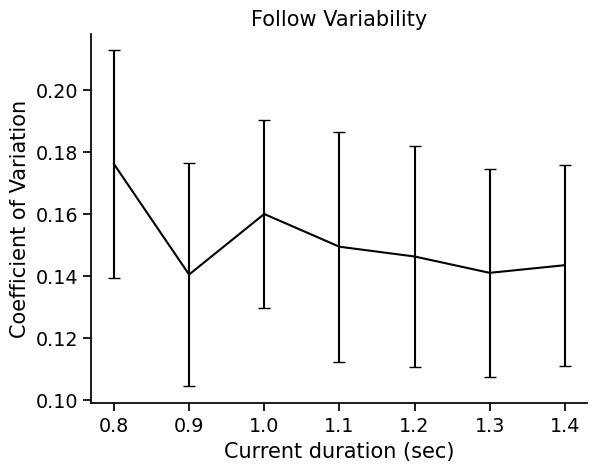

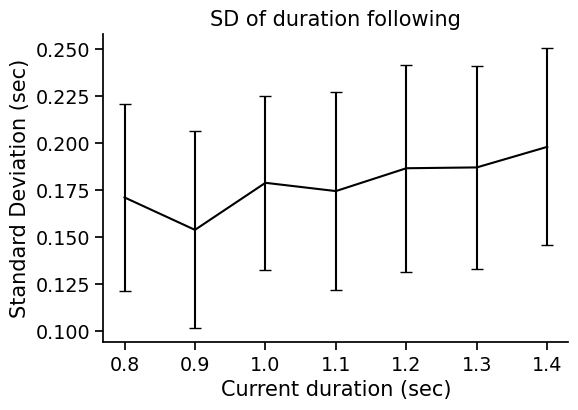

In [127]:
# overall mean follow CV
FlwCV = dataFlw.groupby(['nPar']).agg({"flw":["count","mean","std"]}).reset_index()
FlwCV.columns = ['nPar', 'count', 'mean','std']
FlwCV['cv'] = FlwCV['std']/FlwCV['mean']
# print(FlwCV)
print('mean of overall follow CV:',FlwCV["cv"].mean().round(3))
print('SE of overall follow CV:',FlwCV["cv"].sem().round(3))
# print('【The overall CV compared to zero】')
# print(pg.ttest(FlwCV['cv'], 0).round(3))

# mean CV as a factor of duration
mFlwCVPar = dataFlw.groupby(['nPar', 'curDur']).\
    agg({"flw":["count","mean","std"]}).reset_index()
mFlwCVPar.columns = ['nPar', 'curDur','count', 'mean','std']
mFlwCVPar['cv'] = mFlwCVPar['std']/mFlwCVPar['mean']
mFlwCVAll = mFlwCVPar.groupby(['curDur']).agg({"cv":["count","mean","sem"]}).reset_index()
mFlwCVAll.columns = ['curDur', 'count', 'mCV','seCV']
# print(mFlwCVAll)
# print('【rmANOVA: Duration main effect on mean CV】')
# aov_flwcv_dur = rmANOVA_gg_Long(mFlwCVAll, 'cv', ['curDur'], 'nPar')
# print(aov_flwcv_dur)

# plot CV
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mCV', yerr='seCV', data=mFlwCVAll, 
             color='black', capsize=4)
plt.xticks(mFlwCVAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Coefficient of Variation')
plt.title('Follow Variability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot SD
mFlwSDAll = mFlwCVPar.groupby(['curDur']).agg({"std":["count","mean","sem"]}).reset_index()
mFlwSDAll.columns = ['curDur', 'count', 'mSD','seSD']
#print(mFlwSDAll)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.errorbar(x='curDur',y='mSD',yerr='seSD',data=mFlwSDAll,color='black',capsize=4)
plt.xticks(mFlwSDAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Standard Deviation (sec)')
plt.title('SD of duration following')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### 2.2 Central tendency effect

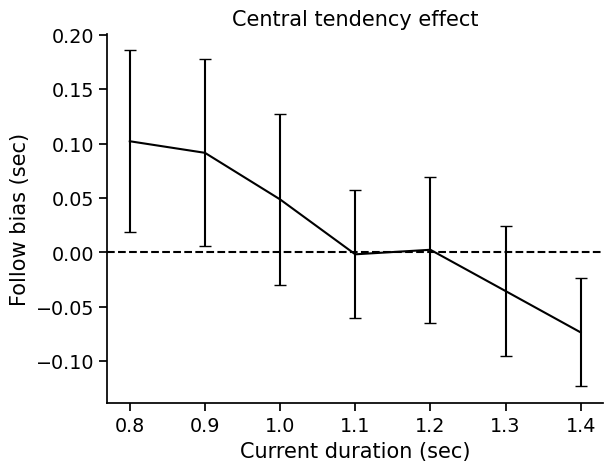

In [128]:
# Central tendency based on Reproduction Bias
mFlwBiasDurPar = dataFlw.groupby(['nPar', 'curDur']).curBias.mean().reset_index()
mFlwBiasDurAll = mFlwBiasDurPar.groupby('curDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mFlwBiasDurAll.columns = ['curDur', 'count', 'mBias','seBias']
#print(mFlwBiasDurAll)

# rmANOVA: mean bias as a factor of duration
# print('【rmANOVA: Duration main effect on mean follow bias】')
# aov_flwbias_dur = rmANOVA_gg_Long(mFlwBiasDurPar, 'curBias', ['curDur'], 'nPar')
# print(aov_flwbias_dur)

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mBias', yerr='seBias', data=mFlwBiasDurAll, 
             color='black', capsize=4)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mFlwBiasDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Follow bias (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(figsDir + '/CT_FlwErr.png', bbox_inches='tight')

# # Central tendency based on Reproduction
# mFlwDurPar = dataFlw.groupby(['nPar', 'curDur']).flw.mean().reset_index()
# mFlwDurAll = mFlwDurPar.groupby('curDur').\
#     agg({"flw":["count","mean","sem"]}).reset_index()
# mFlwDurAll.columns = ['curDur', 'count', 'mRpr','seRpr']
# # print(mFlwDurAll)

# # plot central tendency
# fig, ax = plt.subplots()
# plt.errorbar(x='curDur', y='mRpr', yerr='seRpr', data=mFlwDurAll, 
#              color='black', capsize=4)
# plt.plot([0.8, 1.4], [0.8, 1.4], 'k-', lw=1, dashes=[2, 2])
# plt.xticks(mFlwDurAll.curDur)
# plt.xlabel('Current duration (sec)')
# plt.ylabel('Follow (sec)')
# plt.title('Central tendency effect')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # plt.savefig(figsDir + '/CT_Flw.png', bbox_inches='tight')

### 2.3 Sequential effect or Serial dependence

In [129]:
# overall Sequential effect (based on Reproduction Bias)
mFlwBiasPreDurPar = dataFlw_pre.groupby(['nPar','preDur']).curBias.mean().reset_index()
mFlwBiasPreDurAll = mFlwBiasPreDurPar.groupby('preDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mFlwBiasPreDurAll.columns = ['preDur', 'count', 'mBias','seBias']
# print(mFlwBiasPreDurAll)

# rmANOVA: mean bias as a factor of pre-duration
# print('【rmANOVA of mean follow Bias on preDuration】')
# aov_flwbias_preDur = rmANOVA_gg_Long(mFlwBiasPreDurPar, 'curBias', ['preDur'], 'nPar')
# print(aov_flwbias_preDur)

# plot sequential effect
# fig, ax = plt.subplots()
# plt.errorbar(x='preDur', y='mBias', yerr='seBias', data=mFlwBiasPreDurAll, 
#              color='black', capsize=4)
# # plt.axhline(y=0, color='black', linestyle='--')
# plt.xticks(mFlwBiasPreDurAll.preDur)
# plt.xlabel('Duration of previous n-1 trial (sec)')
# plt.ylabel('Follow bias (sec)')
# plt.title('overall Sequential effect')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_FlwErr.png', bbox_inches='tight')

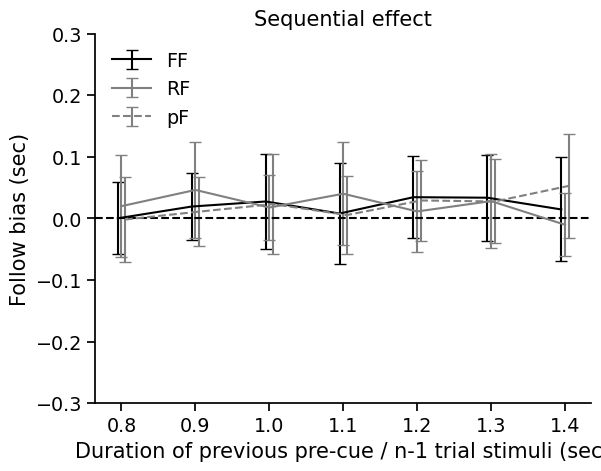

In [130]:
# Sequential effect between FF and RF
seqFlwTaskPar = dataFlw_pre.groupby(['nPar', 'preTask', 'preDur']).curBias.mean().reset_index()
seqFlwTaskAll = seqFlwTaskPar.groupby(['preTask', 'preDur']).\
    agg({"curBias":["count","mean","sem"]}).reset_index()
seqFlwTaskAll.columns = ['preTask', 'preDur', 'count', 'mBias','seBias']
# print(seqFlwTaskAll)

# plot sequential effect between FF and RF
data_FF = seqFlwTaskAll.query('preTask=="following"')
data_RF = seqFlwTaskAll.query('preTask=="reproduction"')
data_pF = dataFlw.query('curTask=="following"').\
    groupby(['nPar','curPreCueDur']).curBias.mean().reset_index().\
    groupby(['curPreCueDur']).agg({"curBias":["count","mean","sem"]}).reset_index()
data_pF.columns = ['curPreCueDur', 'count', 'mBias','seBias']

fig, ax = plt.subplots()
ax.errorbar(data_FF.preDur-0.005, data_FF.mBias, data_FF.seBias, 
             color='black', capsize=4, label='FF')
ax.errorbar(data_RF.preDur, data_RF.mBias, data_RF.seBias, 
             color='grey', capsize=4, label='RF')
ax.errorbar(data_pF.curPreCueDur+0.005, data_pF.mBias, data_pF.seBias, 
             color='grey', capsize=4, label='pF', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-0.3, 0.3)
plt.xticks(data_FF.preDur)
plt.xlabel('Duration of previous pre-cue / n-1 trial stimuli (sec)')
plt.ylabel('Follow bias (sec)')
plt.title('Sequential effect')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(figsDir + '/SeqEff_FFvsRF.png', bbox_inches='tight')

mean SDI slope in FF:  0.03
std SDI slope in FF:  0.053
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  0.50461    5   two-sided  0.63528  [-0.12, 0.18]  0.20601  0.414   

          power  
T-test  0.07002  
mean SDI slope in RF:  -0.035
std SDI slope in RF:  0.025
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test -1.24804    5   two-sided  0.26727  [-0.11, 0.04]  0.50951  0.657   

          power  
T-test  0.17541  
【Comparison of SDI in FF vs RF】
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  0.88605    5   two-sided  0.41616  [-0.12, 0.25]  0.57317  0.507   

          power  
T-test  0.20907  
              T  dof alternative    p-val         CI95%  cohen-d   BF10  \
T-test  2.86839    5   two-sided  0.03506  [0.01, 0.14]  1.17102  2.708   

          power  
T-test  0.63454  


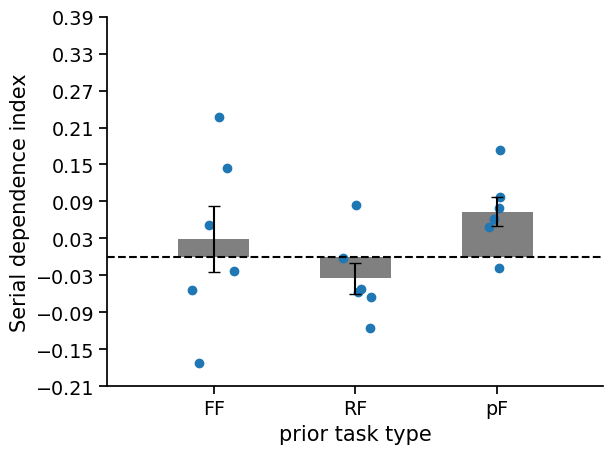

In [131]:
# calculate SDI and plot
dataFF = dataFlw_pre.query('preTask=="following"')
dataRF = dataFlw_pre.query('preTask=="reproduction"')

slope_1, slope_FF_sdi, int_1 = LM_2F(dataFF, ['curDur','preDur','curBias'])
print("mean SDI slope in FF: ", slope_FF_sdi.mean().round(3))
print("std SDI slope in FF: ", round(slope_FF_sdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_FF_sdi, 0).round(5))

slope_1, slope_RF_sdi, int_1 = LM_2F(dataRF, ['curDur','preDur','curBias'])
print("mean SDI slope in RF: ", slope_RF_sdi.mean().round(3))
print("std SDI slope in RF: ", round(slope_RF_sdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_RF_sdi, 0).round(5))

print("【Comparison of SDI in FF vs RF】")
print(pg.ttest(slope_FF_sdi, slope_RF_sdi, paired=True).round(5))

## for pilot only
# reg = lm().fit(dataFF[['curDur', 'preDur']], dataFF['curBias'])
# slope_FF_cti = reg.coef_[0]
# slope_FF_sdi = reg.coef_[1]

# reg2 = lm().fit(dataRF[['curDur', 'preDur']], dataRF['curBias'])
# slope_RF_cti = reg2.coef_[0]
# slope_RF_sdi = reg2.coef_[1]

# calculate the serial dependence of pre-cue stimuli in follow condition
slp_1, slope_csdi, int_1 = LM_2F(dataFlw.query('curTask=="following"'), ['curDur','curPreCueDur','curBias'])
print(pg.ttest(slope_csdi, 0).round(5))

# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,4), [np.mean(slope_FF_sdi), np.mean(slope_RF_sdi), np.mean(slope_csdi)], color='grey', width=0.5)
plt.errorbar(np.arange(1,4), [np.mean(slope_FF_sdi), np.mean(slope_RF_sdi), np.mean(slope_csdi)],
             yerr=[np.std(slope_FF_sdi)/np.sqrt(nPar), np.std(slope_RF_sdi)/np.sqrt(nPar), np.std(slope_csdi)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2, (np.random.random(nPar)-0.5)*0.3+3], \
            [slope_FF_sdi, slope_RF_sdi, slope_csdi])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,3.75)
plt.xticks(np.arange(1,4), ['FF', 'RF', 'pF'])
plt.yticks(np.arange(-0.21, 0.43, 0.06))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(figsDir + '/SeqEff_FFvsRF_SDI.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

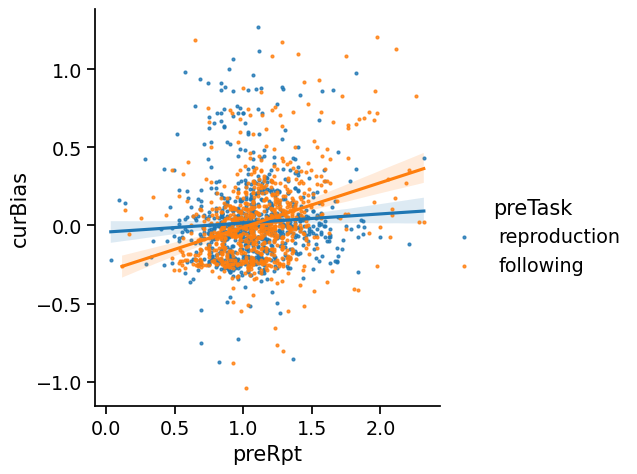

In [132]:
plt.figure()
sns.lmplot(data=dataFlw_pre.query('preRpt<3'), x="preRpt", y="curBias", hue='preTask', scatter_kws={"s": 4}) # 
plt.savefig(figsDir + '/SeqEff_FFvsRF_DCI_scatter.png', bbox_inches='tight')

mean SDI slope in FF:  0.051
std SDI slope in FF:  0.033
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  1.42386    5   two-sided  0.21378  [-0.04, 0.14]  0.58129  0.758   

          power  
T-test  0.21364  
mean SDI slope in RF:  0.059
std SDI slope in RF:  0.05
              T  dof alternative    p-val         CI95%  cohen-d   BF10  \
T-test  1.07726    5   two-sided  0.33057  [-0.08, 0.2]  0.43979  0.577   

          power  
T-test  0.14302  
【Comparison of SDI in FF vs RF】
              T  dof alternative    p-val         CI95%  cohen-d   BF10  \
T-test -0.19898    5   two-sided  0.85011  [-0.11, 0.1]  0.07071  0.379   

          power  
T-test  0.05234  


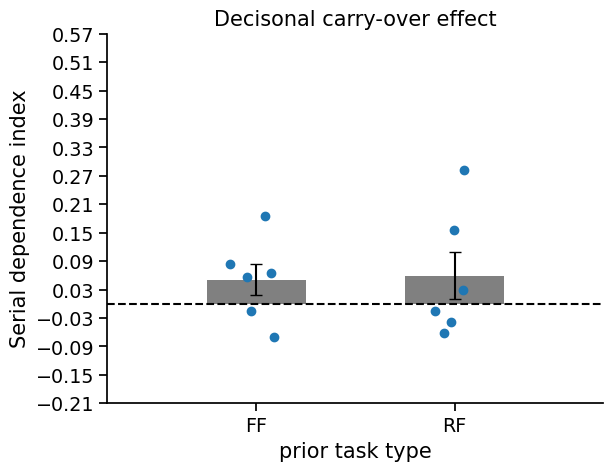

In [133]:
# calculate Decisional carry-over index (DCI) and plot
slope_1, slope_FF_dci, int_1 = LM_2F(dataFF, ['curDur','preRpt','curBias'])
print("mean SDI slope in FF: ", slope_FF_dci.mean().round(3))
print("std SDI slope in FF: ", round(slope_FF_dci.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_FF_dci, 0).round(5))

slope_1, slope_RF_dci, int_1 = LM_2F(dataRF, ['curDur','preRpt','curBias'])
print("mean SDI slope in RF: ", slope_RF_dci.mean().round(3))
print("std SDI slope in RF: ", round(slope_RF_dci.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_RF_dci, 0).round(5))

print("【Comparison of SDI in FF vs RF】")
print(pg.ttest(slope_FF_dci, slope_RF_dci, paired=True).round(5))

# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,3), [np.mean(slope_FF_dci), np.mean(slope_RF_dci)], color='grey', width=0.5)
plt.errorbar(np.arange(1,3), [np.mean(slope_FF_dci), np.mean(slope_RF_dci)],
             yerr=[np.std(slope_FF_dci)/np.sqrt(nPar), np.std(slope_RF_dci)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2],\
            [slope_FF_dci, slope_RF_dci])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,2.75)
plt.xticks(np.arange(1,3), ['FF', 'RF'])
plt.yticks(np.arange(-0.21, 0.61, 0.06))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
plt.title('Decisonal carry-over effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(figsDir + '/SeqEff_FFvsRF_DCI.png', bbox_inches='tight')